In [1]:
import numpy as np
import matplotlib.pyplot as plt
import skimage
from skimage import io, color, filters, feature, measure
import pyclesperanto_prototype as cle
from scipy import ndimage as ndi
from scipy import stats
import pandas as pd

In [2]:
import os
import re

In [3]:
img_path = "./data_04_04/images/"
msk_path = "./data_04_04/masks/"

img_list = os.listdir(img_path)
msk_list = os.listdir(msk_path)

In [4]:
def sort_by_number(list_name):
    list_name.sort(key=lambda f: int(re.sub('\D', '', f)))
    return list_name

In [5]:
img_list = sort_by_number(img_list)
msk_list = sort_by_number(msk_list)

In [6]:
assert len(img_list) == len(msk_list)
print("Number of images: ", len(img_list))
print("Number of masks: ", len(msk_list))

Number of images:  99
Number of masks:  99


In [7]:
# Check that position in file name is corresponding to it's position in the list
def pos_check(file_list, file_path):
    file_path = sort_by_number(os.listdir(file_path))
    for actual_name, expected_name in zip(file_list, file_path):
        if actual_name.split(" ")[1][1:3] == expected_name.split(" ")[1][1:3]:
            continue
        else:
            print("Missing name: ", actual_name)
            break
    else:
        print("All good!")

In [8]:
pos_check(img_list, img_path)

All good!


In [9]:
pos_check(msk_list, msk_path)

All good!


In [10]:
import dask.array as da

In [11]:
# images = da.array([io.imread(img_path + file_name, as_gray=True) for file_name in img_list])
# masks = da.array([io.imread(msk_path + file_name, as_gray=True) for file_name in msk_list])

In [12]:
images = np.array([io.imread(img_path + file_name, as_gray=True) for file_name in img_list])
masks = np.array([io.imread(msk_path + file_name, as_gray=True) for file_name in msk_list])

In [13]:
# Plot images and masks
def plot_images(images, masks, n=5, size=(6, 10)):
    # Use random images and masks
    idx = np.random.randint(0, images.shape[0], n)
    images = images[idx]
    masks = masks[idx]
    fig, ax = plt.subplots(n, 2, figsize=size)
    # Space between subplots
    fig.subplots_adjust(hspace=0.5)
    for i in range(n):
        ax[i, 0].set_title(f"Image {i}")
        ax[i, 0].imshow(images[i], cmap="gray")
        ax[i, 1].set_title(f"Mask {i}")
        ax[i, 1].imshow(masks[i], cmap="gray")
    plt.show()

In [57]:
# Plot labels using color.label2rgb
def plot_labels(labels, images, n=5, size=(6, 10)):
    fig, ax = plt.subplots(n, 2, figsize=size)
    # Space between subplots
    fig.subplots_adjust(hspace=0.5)
    for i in range(n):
        ax[i, 0].set_title(f"Image {i}")
        ax[i, 0].imshow(images[i], cmap="gray")
        ax[i, 1].set_title(f"Labels {i}")
        ax[i, 1].imshow(color.label2rgb(labels[i], images[i], bg_label=0))
    plt.show()

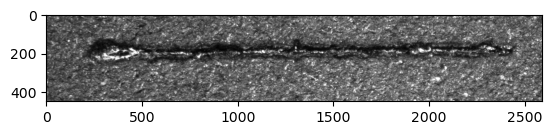

In [15]:
plt.imshow(images[90][700:1150], cmap="gray")
plt.show()

In [16]:
images_cropped = images[:, 700:1150, :]
masks_cropped = masks[:, 700:1150, :]

del images, masks

### Basic statistics

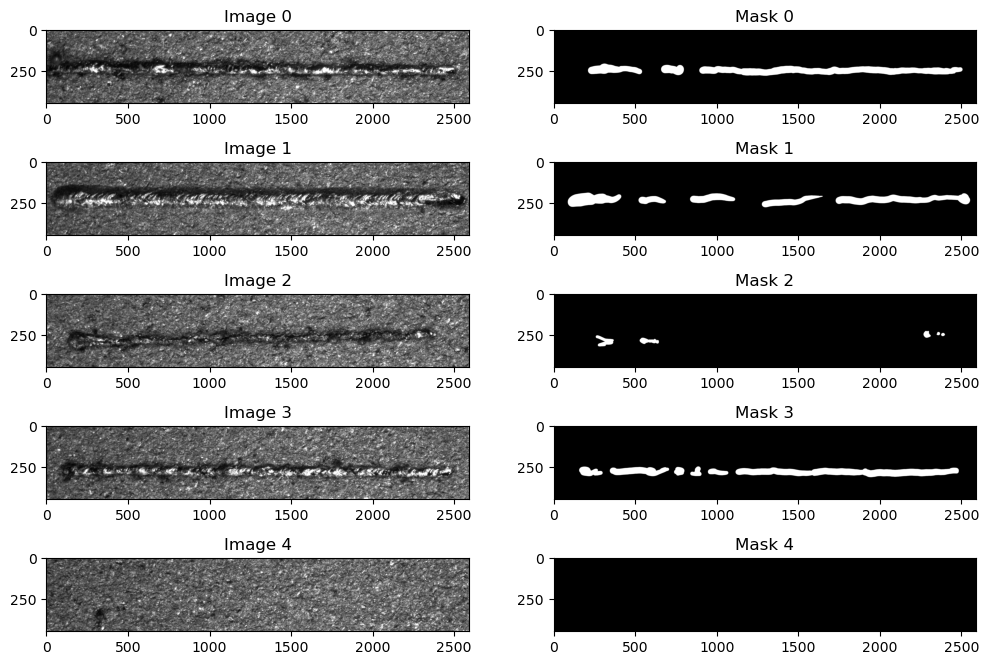

In [17]:
plot_images(images_cropped, masks_cropped, size=(12,8))

In [18]:
masks_cropped.shape

(99, 450, 2592)

In [29]:
labels = measure.label(masks_cropped, background=0)

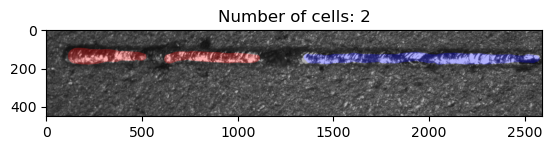

In [39]:
plt.imshow(color.label2rgb(labels[60], image=images_cropped[60], bg_label=0))
plt.title(f"Number of cells: {np.unique(labels[60]).shape[0] - 1}")
plt.show()

In [55]:
continious_tracks = []
# Fill list with continious tracks
for i in range(labels.shape[0]):
    if np.unique(labels[i]).shape[0] == 2:
        continious_tracks.append(labels[i])
continious_tracks = np.array(continious_tracks)

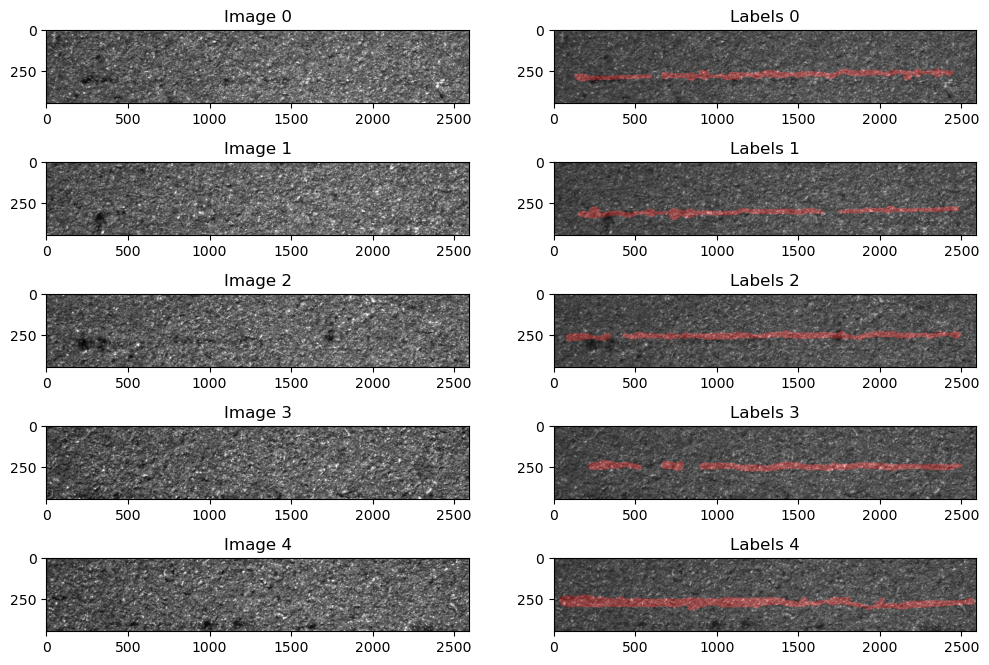

In [58]:
plot_labels(continious_tracks, images_cropped, size=(12,8))

In [54]:
propsTable = pd.DataFrame(measure.regionprops_table(continious_tracks, properties=["label",\
    "area", "bbox", "bbox_area", "extent", "solidity"]), c)
propsTable

AttributeError: 'list' object has no attribute 'ndim'